['setosa', 'versicolor', 'virginica']
[0 1 2]
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   labels  
0       0  
1       0  
2       0  
3       0  
4       0  


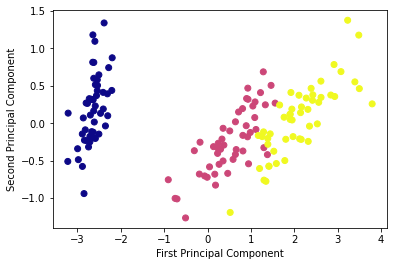

          0         1
0 -2.684126  0.319397
1 -2.714142 -0.177001
2 -2.888991 -0.144949
3 -2.745343 -0.318299
4 -2.728717  0.326755
150


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA

# load iris dataset into a pandas dataframe
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# encode label names into integers
le = preprocessing.LabelEncoder()
le.fit(iris.target_names)
# print classes names and their corresponding integer values

print(list(le.classes_))
print(le.transform(list(le.classes_)))

df['labels'] = np.array([iris.target_names[i] for i in iris.target])
df['labels'] = le.transform(df['labels'])

# print the first 5 rows of the new dataframe
print(df.head())

# pca on the iris dataset
pca = PCA(n_components=2)
pca.fit(df.iloc[:, 0:4])
X_pca = pca.transform(df.iloc[:, 0:4])

# plot the first two principal components of each point to learn about the data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['labels'], cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# replace original data with the new principal components
df_pca = pd.DataFrame(X_pca)
print(df_pca.head())

print(len(df))

# put in y values
df_pca['labels'] = df['labels']


In [2]:
def naive_kernel(x):
    return np.linalg.norm(x) <= 1

def epanechnikov_kernel(x):
    return max(3/4 * (1 - np.linalg.norm(x)**2), 0)

def gaussian_kernel(x):
    return 1 / (np.sqrt(2 * np.pi)) * np.exp(-1/2 * np.linalg.norm(x)**2)

In [3]:
def m_n_kernel(x, X, Y, h, kernel):
    denominator = sum([kernel((x - x_i)/h) for x_i in X])

    if denominator == 0:
        return 0
    
    return sum([y_i * kernel((x - x_i)/h) for (x_i, y_i) in zip(X, Y)]) / denominator

    # return 1/(len(D_n) * h**2) * sum([kernel((x - x_i)/h) for x_i in D_n])

In [36]:
print(df_pca.iloc[137, -1])
m_n_kernel(df_pca.iloc[137, 0:-1], df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, 0.5, epanechnikov_kernel)

2


1.9727277121914046

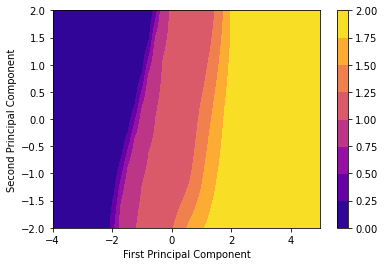

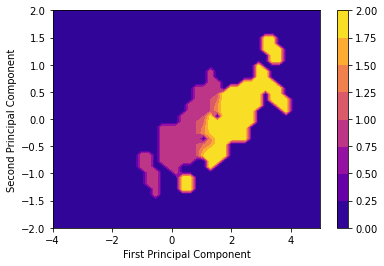

In [5]:
# visualize the global regression function

# create a grid of points
x = np.linspace(-4, 5, 40)
y = np.linspace(-2, 2, 40)
xx, yy = np.meshgrid(x, y)
z_1 = np.zeros((40, 40))
z_2 = np.zeros((40, 40))

# calculate the regression function for each point in the grid
for i in range(40):
    for j in range(40):
        z_1[i, j] = m_n_kernel([xx[i, j], yy[i, j]], df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, 0.5, gaussian_kernel)
        z_2[i, j] = m_n_kernel([xx[i, j], yy[i, j]], df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, 0.2, epanechnikov_kernel)

# plot the regression function
plt.contourf(xx, yy, z_1, cmap='plasma')
plt.colorbar()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

plt.contourf(xx, yy, z_2, cmap='plasma')
plt.colorbar()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [6]:
def m_n_knn(x, X, Y, k):
    distances = [np.linalg.norm(x_i - x) for x_i in X]
    k_nearest = np.argsort(distances)[:k]
    
    return sum([Y[i] for i in k_nearest]) / k

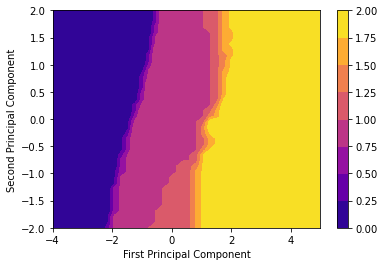

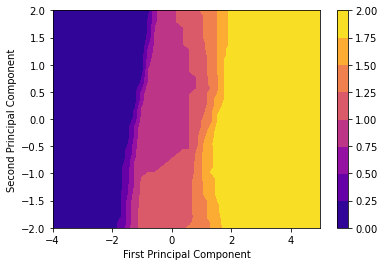

In [37]:
# visualize the global regression function

# create a grid of points
x = np.linspace(-4, 5, 40)
y = np.linspace(-2, 2, 40)
xx, yy = np.meshgrid(x, y)
z_1 = np.zeros((40, 40))
z_2 = np.zeros((40, 40))

# calculate the regression function for each point in the grid
for i in range(40):
    for j in range(40):
        z_1[i, j] = m_n_knn([xx[i, j], yy[i, j]], df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, 5)
        z_2[i, j] = m_n_knn([xx[i, j], yy[i, j]], df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, 20)

# plot the regression function
plt.contourf(xx, yy, z_1, cmap='plasma')
plt.colorbar()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

plt.contourf(xx, yy, z_2, cmap='plasma')
plt.colorbar()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [8]:
def train_test_split(X, Y, test_size, random_state=None):
    prev_seed = np.random.get_state()[1][0]
    if random_state is not None:
        np.random.seed(random_state)
    
    test_indices = np.random.choice(len(X), int(test_size * len(X)), replace=False)
    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)

    np.random.seed(prev_seed)

    return X.iloc[train_indices], X.iloc[test_indices], Y.iloc[train_indices], Y.iloc[test_indices]

In [9]:
# K-fold cross validation

def squared_loss(Y_true, Y_pred):
    return (Y_true - Y_pred)**2

def error_function(Y_true, Y_pred, loss_function):
    return np.mean(loss_function(Y_true, Y_pred))

def k_fold_cross(X, Y, estimator, parameters, loss_function, k=5):
    # split the data into k folds
    X_folds = np.array_split(X, k)
    Y_folds = np.array_split(Y, k)

    # Ordered dict to store the errors for each parameter
    errors = {}

    # loop over parameters
    for parameter in parameters:
        # loop over the folds
        # initialize the error
        error = 0

        for i in range(k):
            # create the training and testing sets
            X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
            Y_train = np.concatenate([Y_folds[j] for j in range(k) if j != i])
            X_test = X_folds[i]
            Y_test = Y_folds[i]

            # train the model
            # estimator.fit(X_train, Y_train, **parameters)

            # predict the test set
            Y_pred = np.array([estimator(x, X_train, Y_train, **parameter) for x in X_test])

            # calculate the error
            error += error_function(Y_test, Y_pred, loss_function)
        
        # calculate the average error
        error /= k

        # store the error
        errors[error] = parameter

    # return the best parameters
    min_error = min(errors.keys())
    return errors[min(errors.keys())], min_error


    

In [10]:
from itertools import product

print(k_fold_cross(df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, m_n_knn, [{'k': k} for k in range(1, 20)], squared_loss, k=10))

print(k_fold_cross(df_pca.iloc[:, :-1].values, df_pca.iloc[:, -1].values, m_n_kernel,
             [{'h': h, 'kernel': k} for (h, k) in product(np.linspace(0.01, 1.0, 40), [naive_kernel, epanechnikov_kernel, gaussian_kernel])],
             squared_loss, k=10))


({'k': 2}, 0.03166666666666666)
({'h': 0.08615384615384615, 'kernel': <function gaussian_kernel at 0x7f7ff46419d0>}, 0.035798363009270716)


{'h': 0.18769230769230769, 'kernel': <function gaussian_kernel at 0x7f7ff46419d0>}
Test error: 0.035565537881057985


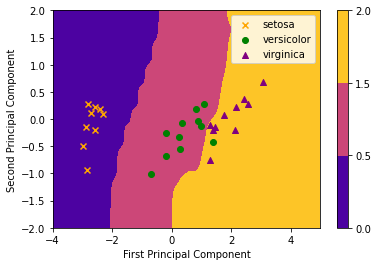

In [11]:
# Evaluate the performance of the two methods

# split the data into training and testing sets
# from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_pca.iloc[:, :-1], df_pca.iloc[:, -1], test_size=0.2, random_state=41)

params, err = k_fold_cross(X_train.values, Y_train.values, m_n_kernel,
             [{'h': h, 'kernel': k} for (h, k) in product(np.linspace(0.01, 1.0, 40), [naive_kernel, epanechnikov_kernel, gaussian_kernel])],
             squared_loss, k=10)

print(params)
m_n = lambda x: m_n_kernel(x, X_train.values, Y_train.values, **params)

# calculate test error
Y_pred = np.array([m_n(x) for x in X_test.values])
test_error = error_function(Y_test.values, Y_pred, squared_loss)
print('Test error: {}'.format(test_error))

# create a grid of points
x = np.linspace(-4, 5, 40)
y = np.linspace(-2, 2, 40)
xx, yy = np.meshgrid(x, y)
z_1 = np.zeros((40, 40))
z_2 = np.zeros((40, 40))

# calculate the regression function for each point in the grid
for i in range(40):
    for j in range(40):
        z_1[i, j] = m_n([xx[i, j], yy[i, j]])

# plot the regression function
levels = [0.0, 0.5, 1.5, 2]
plt.contourf(xx, yy, z_1, levels, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# plot the training data in a different color
# plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis', marker='o')

# colorbar
plt.colorbar()

# get labelnames from the encoder
labelnames = le.inverse_transform([0, 1, 2])

plt.scatter(X_test.iloc[:, 0][Y_test==0], X_test.iloc[:, 1][Y_test==0], c='orange', marker='x', label=labelnames[0])
plt.scatter(X_test.iloc[:, 0][Y_test==1], X_test.iloc[:, 1][Y_test==1], c='green', marker='o', label=labelnames[1])
plt.scatter(X_test.iloc[:, 0][Y_test==2], X_test.iloc[:, 1][Y_test==2], c='purple', marker='^', label=labelnames[2])

# make a legend
plt.legend()

plt.show()


In [25]:
# putting music_genre.csv into a dataframe

df = pd.read_csv('music_genre.csv')

# get rows that have values in column 18
df = df.drop(df[df.iloc[:, 18].notnull()].index)

# drop the last two columns
df = df.iloc[:, :-2]

# print(df.dtypes)

# print(df.head())
# print(len(df))

# select the columns that we want to use, namely 3 5 and 6
df = df.iloc[:, [3, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17]]  # 9 and 12 are strings
# Y = df.iloc[:, 17]
# print(df.head())
labels = df.iloc[:, -1].unique()

print(labels)

df = df.drop(df[(df.iloc[:, -1] != labels[0]) & (df.iloc[:, -1] != labels[3])].index)



df = df.dropna()

df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

print(df.tail())

df.iloc[:, -1] = df.iloc[:, -1].replace(labels[0], 0)
df.iloc[:, -1] = df.iloc[:, -1].replace(labels[3], 1)

df = df.dropna()

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]


# drop nan values
# X = X.dropna()

# drop same rows in Y
# Y = Y.drop(Y[X.index].index)

# print(X.head())

# print(X.head())
# print(Y.head())




# X = X.drop(X[(Y != labels[0]) & (Y != labels[1])].index)

# print(X.head())

# Set the labels to 0 and 1

# get max and min values for each column
maxes = X.max()
mins = X.min()

# print column name and max and min values
for i in range(len(maxes)):
    print('%s: %f-%f' % (X.columns[i], mins[i], maxes[i]))


# rescale each column to have mean 0 and standard deviation 1

mu = X.mean()
sigma = X.std()

X = (X - mu) / sigma

# print(X.head())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print(len(X_train))
print(len(Y_train))




['Electronic' 'Anime' nan 'Jazz' 'Alternative' 'Country' 'Rap' 'Blues'
 'Rock' 'Classical' 'Hip-Hop']
       popularity  acousticness  danceability   energy  instrumentalness  \
15000        41.0      742.0000         0.671    0.438          0.000000   
15001        54.0        0.8800       188.000  307.000          0.000832   
15002        60.0        0.9400       497.000  206.000          0.000001   
15003        41.0        0.0798         0.530  478.000        818.000000   
15004        36.0      384.0000         0.678  402.000          0.034700   

       liveness  loudness  speechiness       tempo  valence music_genre  
15000    0.0601     -9.15       0.0651  123395.000    0.801        Jazz  
15001  307.0000 -12212.00       0.0305      89.107  165.000        Jazz  
15002  104.0000 -12637.00      31.0000      81.630  181.000        Jazz  
15003  121.0000 -12703.00       0.0343      85.702    0.117        Jazz  
15004    0.1640 -10566.00       0.0667  171985.000  544.000        Jazz

/home/tobias/anaconda3/envs/maths/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (4,11,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [26]:
print('Find best parameters for kernel')
# param, err = k_fold_cross(X_train.values, Y_train.values, m_n_kernel, [{'h': 2**(h), 'kernel': gaussian_kernel} for h in range(0, 1)], squared_loss, k=5)
# print(param, err)
# m_n = lambda x: m_n_knn(x, X_train.values, Y_train.values, **param)

Find best parameters for kernel


In [39]:
m_n = lambda x: m_n_kernel(x, X_train.values, Y_train.values, kernel=gaussian_kernel, h=0.8)

print(X_test.iloc[0].values)
print(Y_test.iloc[0])

for i in range(10):
    print(m_n(X_test.iloc[i].values), Y_test.iloc[i])

# choose 100 random points from the test set
sample = X_test.sample(100, random_state=1337).index

print(len(X_test))
print(len(Y_test))

Y_test.loc[sample].values

# calculate the error
Y_pred = np.array([(0 if m_n(x) < 0.5 else 1) for x in X_test.loc[sample].values])

test_error = error_function(Y_test.loc[sample].values, Y_pred, squared_loss)
print('Test error: {}'.format(test_error))

[-1.19346906 -0.68739204  0.74978516  1.47310082  0.70692523 -0.75574499
  0.18705397 -0.42887074  1.13797016  0.91490103]
0
0.2207166462285122 0
0.21243959240644192 0
0.055393569687909 0
0.3441718845585802 0
0.17986501195114782 0
0.6967445335936095 1
0.154724429562314 0
0.5742406645408562 1
0.3939555253079088 1
0.3376630606318878 0
898
898
Test error: 0.24


In [35]:
# popularity: 0.000000-96.000000
# acousticness: 0.000002-996.000000
# danceability: 0.059600-976.000000
# energy: 0.002110-999.000000
# instrumentalness: 0.000000-986.000000
# liveness: 0.017300-986.000000
# loudness: -32798.000000-1585.000000
# speechiness: 0.022600-939.000000
# tempo: 46.483000-220041.000000
# valence: 0.020500-992.000000

popularity = 10.0
acousticness = 802.0
danceability = 350.0
energy = 999.0
instrumentalness = 152.0
liveness = 600.0
loudness = 1400.0
speechiness = 900.0
tempo = 200000.0
valence = 50.0

# normalize and standardize

x = np.array([popularity, acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence] )

x = (x - mu) / sigma

m_n(x)

0.7178956809880647